In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import albumentations
import pandas as pd
import cv2
import numpy as np
import timm
import torch
import torch.nn as nn
from sklearn import metrics

from tqdm import tqdm
import math

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

In [3]:
from model import PetfinderModel

In [4]:
import cuml, pickle
from cuml.svm import SVR
print('RAPIDS version',cuml.__version__,'\n')

LOAD_SVR_FROM_PATH = None

df = pd.read_csv('../datasets/kaggle/petfinder_clean/train.csv')
print('Train shape:', df.shape )
df.head()

RAPIDS version 21.10.00 

Train shape: (9885, 14)


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [5]:
from pprint import pprint
from box import Box

config = {
    'debug': False,
    'name': 'Petfinder',
    'seed': 3407,
    'n_splits': 5,
    'epochs': 5,
    'root': "../datasets/kaggle/petfinder_clean",
    'image_size_tta': 440,
    'image_size': 384,
    'work_dir': './checkpoint',
    'log_level': 'INFO',
    'log_average_filter':['pred', 'label'],
    'log_config': {
        'interval': 10,
        'hooks' : [
            dict(name='PetfinderLoggerHook'),
            # dict(name='TextLoggerHook'),
        ]
    },
    'model': {
        'name': 'swin_large_patch4_window12_384',
        'feature_dim': 128,
        'output_dim': 1,
    },
    'train_loader': {
        'batch_size': 32,
        'num_workers': 10,
        'shuffle': True,
        'drop_last': False,
        'pin_memory': False,
    },
    'val_loader': {
        'batch_size': 32,
        'num_workers': 10,
        'shuffle': False,
        'drop_last': False,
        'pin_memory': False,
    },
    'optimizer': {
        'name': 'AdamW',
        'lr': 1e-5,
    },
    'optimizer_config': {
        'grad_clip': None
    },
    'lr_config': {
        'policy': 'CosineAnnealing',
        'by_epoch': False,
        'min_lr_ratio': 1e-2,
        'warmup': 'linear',
        'warmup_ratio': 1e-3,
        'warmup_iters': 200,
        'warmup_by_epoch': False
    },
    'workflow': [('train', 1), ('val', 1)],
    'checkpoint_config': {
        'interval': 1,
    },
    'earlystopping_config': {
        'monitor': 'mse',
        'patience': 2,
        'mode': 'min',
    }
}


config = Box(config)
pprint(config)


{'checkpoint_config': <Box: {'interval': 1}>,
 'debug': False,
 'earlystopping_config': {'mode': 'min',
                          'monitor': 'mse',
                          'patience': 2},
 'epochs': 5,
 'image_size': 384,
 'image_size_tta': 440,
 'log_average_filter': <BoxList: ['pred', 'label']>,
 'log_config': {'hooks': <BoxList: [{'name': 'PetfinderLoggerHook'}]>,
                'interval': 10},
 'log_level': 'INFO',
 'lr_config': {'by_epoch': False,
               'min_lr_ratio': 0.01,
               'policy': 'CosineAnnealing',
               'warmup': 'linear',
               'warmup_by_epoch': False,
               'warmup_iters': 200,
               'warmup_ratio': 0.001},
 'model': {'feature_dim': 128,
           'name': 'swin_large_patch4_window12_384',
           'output_dim': 1},
 'n_splits': 5,
 'name': 'Petfinder',
 'optimizer': <Box: {'name': 'AdamW', 'lr': 1e-05}>,
 'optimizer_config': <Box: {'grad_clip': None}>,
 'root': '../datasets/kaggle/petfinder_clean',
 'seed'

In [6]:
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

class PetfinderDataset(Dataset):
    def __init__(
        self, 
        df, 
        transform=None
    ):
        super().__init__()
        self.df = df
        self._X = self.df['file_path']
        self._Y = None
        if 'Pawpularity' in df.keys():
            self._Y = self.df['Pawpularity'].values
        self.transform = transform

    def __len__(self):
        return len(self._X)

    def __getitem__(self, idx):
        image_path = self._X[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        filename = image_path.split('/')[-1]
        if self.transform:
            image = self.transform(image=image)['image']
        if self._Y is not None:
            label = self._Y[idx]
            return {'image': image, 'label': label, 'filename': filename}
        return {'image': image, 'filename': filename}

class PetfinderLoader():
    def __init__(
        self,
        train_df,
        val_df,
        cfg,
    ):
        self._train_df = train_df
        self._val_df = val_df
        self._cfg = cfg

        self.train_transform = A.Compose(
            [
                A.Resize(cfg.image_size, cfg.image_size),
                A.Normalize(
                    mean = [0.485, 0.456, 0.406],
                    std = [0.229, 0.224, 0.225],
                ),
                A.HorizontalFlip(p = 0.5),
                A.VerticalFlip(p = 0.5),
                A.Rotate(limit = 180, p = 0.7),
                A.ShiftScaleRotate(
                    shift_limit = 0.1,
                    scale_limit = 0.1,
                    rotate_limit = 45,
                    p = 0.5
                ),
                A.HueSaturationValue(
                    hue_shift_limit = 0.2,
                    sat_shift_limit = 0.2,
                    val_shift_limit = 0.2,
                    p = 0.5
                ),
                A.RandomBrightnessContrast(
                    brightness_limit = (-0.1, 0.1),
                    contrast_limit = (-0.1, 0.1),
                    p = 0.5
                ),
                ToTensorV2(p=1.0)
            ]
        )

        self.val_transform = A.Compose(
            [
                A.Resize(cfg.image_size, cfg.image_size),
                A.Normalize(
                    mean = [0.485, 0.456, 0.406],
                    std = [0.229, 0.224, 0.225],
                ),
                ToTensorV2(p=1.0)
            ]
        )

        self.test_transform = A.Compose(
            [
                A.Resize(cfg.image_size_tta, cfg.image_size_tta),
                A.Normalize(
                    mean = [0.485, 0.456, 0.406],
                    std = [0.229, 0.224, 0.225],
                ),
                ToTensorV2(p=1.0)
            ]
        )

    def __create_dataset(self, mode="train"):
            if mode == "train":
                return PetfinderDataset(self._train_df, self.val_transform)
            elif mode == "val":
                return PetfinderDataset(self._val_df, self.val_transform)
            else:
                return PetfinderDataset(self._val_df, self.val_transform)


    def train_dataloader(self):
        dataset = self.__create_dataset(mode="train")
        return DataLoader(dataset, **self._cfg.val_loader)

    def val_dataloader(self):
        dataset = self.__create_dataset(mode="val")
        return DataLoader(dataset, **self._cfg.val_loader)

    def test_dataloader(self):
        dataset = self.__create_dataset(mode="test")
        return DataLoader(dataset, **self._cfg.val_loader)

In [7]:
from tqdm import tqdm

class PetfinderModel(nn.Module):
    def __init__(
        self, 
        cfg
    ):
        super(PetfinderModel, self).__init__()
        self._cfg = cfg
        self.backbone = timm.create_model(self._cfg.model.name, pretrained=True, num_classes=0)
        self.num_features = self.backbone.num_features

        self.dense1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.num_features, self._cfg.model.feature_dim)
        )
        self.dense2 = nn.Linear(self._cfg.model.feature_dim, self._cfg.model.output_dim)


    def forward(self, x):
        x1 = self.backbone(x)
        feature  = self.dense1(x1)
        out = self.dense2(feature)
        return out
    
    def get_feature(self, x):
        x1 = self.backbone(x)
        feature = self.dense1(x1)
        return feature
    
    def predict(self, data_loader, device):
        self.eval()
        tk0 = tqdm(data_loader, total=len(data_loader))
        
        for _, batch in enumerate(tk0):
            with torch.no_grad():
                image = batch['image'].to(device)
                feature = self.get_feature(image)
                out = self.dense2(feature)
                out = torch.cat([out, feature], dim=1)
                out = self.process_output(out)
                yield out
                
    def process_output(self, output):
        output = output.cpu().detach().numpy()
        return output

In [8]:
LOAD_SVR_FROM_PATH = "./"

In [9]:
import gc
import torch
import numpy as np
from sklearn.model_selection import StratifiedKFold
df = pd.read_csv(os.path.join(config.root, 'train.csv')) if not config.debug else pd.read_csv(os.path.join(config.root, 'train.csv'))[:1000]
num_bins = int(np.floor(1 + 3.322 * np.log2(len(df))))
df.loc[:, 'bins'] = pd.cut(df['Pawpularity'], bins=num_bins, labels=False)
df['file_path'] = df['Id'].apply(lambda x: os.path.join(config.root, 'train', x + '.jpg'))
skf = StratifiedKFold(n_splits=config.n_splits, shuffle=True, random_state=config.seed)

device = "cuda" if torch.cuda.is_available() else "cpu"

super_final_predictions = []
super_final_predictions2 = []
super_final_oof_predictions = []
super_final_oof_predictions2 = []
super_final_oof_true = []

for fold, (train_idx, val_idx) in enumerate(skf.split(df['file_path'], df['bins'])):
    train_df = df.loc[train_idx].reset_index(drop=True)
    val_df = df.loc[val_idx].reset_index(drop=True)

    Loader = PetfinderLoader(train_df, val_df, config)

    model = PetfinderModel(config)
    model.load_state_dict(torch.load(f"./checkpoint/swin_large_patch4_window12_384_1129/commit_pth/swin_large_patch4_window12_384_fold{fold}.pth"))
    model = model.to(device)

    name = f"SVR_fold_{fold}.pkl"
    if LOAD_SVR_FROM_PATH is None:
        train_predictions = model.predict(Loader.train_dataloader(), device)

        embed = np.array([]).reshape((0,128))
        for preds in train_predictions:
            embed = np.concatenate([embed, preds[:,1:]],axis=0)

        ##################
        # FIT RAPIDS SVR
        print('Fitting SVR...')
        clf = SVR(C=20.0)
        clf.fit(embed.astype('float32'), train_df.Pawpularity.values.astype('int32'))

        ##################
        # SAVE RAPIDS SVR 
        pickle.dump(clf, open(name, "wb"))
    else:
        ##################
        # LOAD RAPIDS SVR 
        print('Loading SVR...',LOAD_SVR_FROM_PATH+name)
        clf = pickle.load(open(LOAD_SVR_FROM_PATH+name, "rb"))
        print('Predicting test...')
        test_predictions = model.predict(Loader.test_dataloader(), device)
        
        final_test_predictions = []
        embed = np.array([]).reshape((0, 128))
        for preds in test_predictions: #tqdm
            final_test_predictions.extend(preds[:,:1].ravel().tolist())
            embed = np.concatenate([embed,preds[:,1:]],axis=0)
        
        final_test_predictions = [sigmoid(x) * 100 for x in final_test_predictions]
        final_test_predictions2 = clf.predict(embed)
        super_final_predictions.append(final_test_predictions)
        super_final_predictions2.append(final_test_predictions2)
        
        final_oof_true = val_df['Pawpularity'].values
        super_final_oof_true.append(final_oof_true)
        
        ##################
        # COMPUTE RSME
        rsme = np.sqrt( np.mean( (super_final_oof_true[-1] - np.array(super_final_predictions[-1]))**2.0 ) )
        print('NN RSME =',rsme,'\n')
        rsme = np.sqrt( np.mean( (super_final_oof_true[-1] - np.array(super_final_predictions2[-1]))**2.0 ) )
        print('SVR RSME =',rsme,'\n')
        
        w = 0.5
        oof2 = (1-w)*np.array(super_final_predictions[-1]) + w*np.array(super_final_predictions2[-1])
        rsme = np.sqrt( np.mean( (super_final_oof_true[-1] - oof2)**2.0 ) )
        print('Ensemble RSME =',rsme,'\n')
        
            

gc.collect()
torch.cuda.empty_cache()
        
        

Loading SVR... ./SVR_fold_0.pkl
Predicting test...


100%|██████████| 62/62 [00:57<00:00,  1.07it/s]


NN RSME = 17.572170559162196 

SVR RSME = 17.9724374864537 

Ensemble RSME = 17.604171661735116 

Loading SVR... ./SVR_fold_1.pkl
Predicting test...


100%|██████████| 62/62 [00:57<00:00,  1.07it/s]


NN RSME = 17.755663981793365 

SVR RSME = 17.835583961057615 

Ensemble RSME = 17.637953948013834 

Loading SVR... ./SVR_fold_2.pkl
Predicting test...


100%|██████████| 62/62 [00:58<00:00,  1.06it/s]


NN RSME = 17.747546540916293 

SVR RSME = 18.134135455969485 

Ensemble RSME = 17.799041300747348 

Loading SVR... ./SVR_fold_3.pkl
Predicting test...


100%|██████████| 62/62 [00:55<00:00,  1.11it/s]


NN RSME = 17.434378040304168 

SVR RSME = 17.591988268515117 

Ensemble RSME = 17.3197793093404 

Loading SVR... ./SVR_fold_4.pkl
Predicting test...


100%|██████████| 62/62 [00:56<00:00,  1.09it/s]


NN RSME = 17.609659087356512 

SVR RSME = 18.114878200566903 

Ensemble RSME = 17.68357968107313 



In [10]:
true = np.hstack(super_final_oof_true)

oof = np.hstack(super_final_predictions)
rsme = np.sqrt( np.mean( (oof - true)**2.0 ))
print('Overall CV NN head RSME =',rsme)

oof2 = np.hstack(super_final_predictions2)
rsme = np.sqrt( np.mean( (oof2 - true)**2.0 ))
print('Overall CV SVR head RSME =',rsme)

oof3 = (1-w)*oof + w*oof2
rsme = np.sqrt( np.mean( (oof3 - true)**2.0 ))
print('Overall CV Ensemble heads RSME with 50% NN and 50% SVR =',rsme)

Overall CV NN head RSME = 17.624289038947293
Overall CV SVR head RSME = 17.930924664572203
Overall CV Ensemble heads RSME with 50% NN and 50% SVR = 17.609621780463787


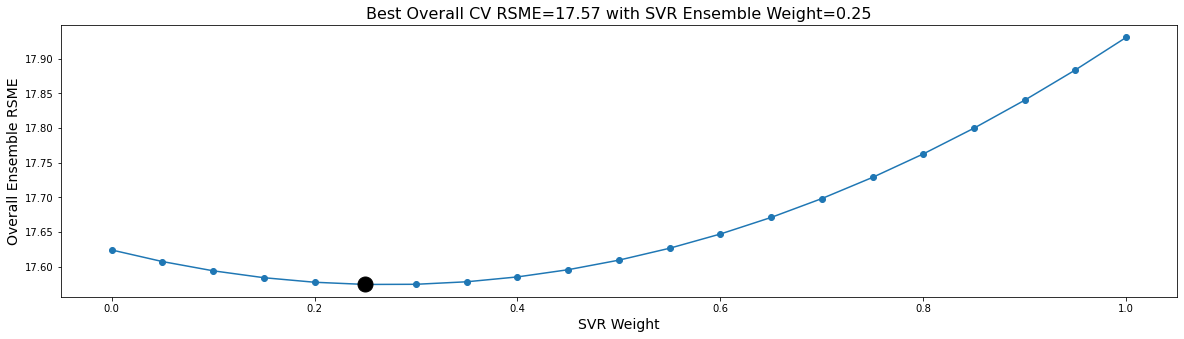

In [11]:
import matplotlib.pyplot as plt

score = []
for ww in np.arange(0,1.05,0.05):
    oof3 = (1-ww)*oof + ww*oof2
    rsme = np.sqrt( np.mean( (oof3 - true)**2.0 ))
    #print(f'{ww:0.2} CV Ensemble RSME =',rsme)
    score.append(rsme)
best_w = np.argmin(score)*0.05

plt.figure(figsize=(20,5))
plt.plot(np.arange(21)/20.0,score,'-o')
plt.plot([best_w],np.min(score),'o',color='black',markersize=15)
plt.title(f'Best Overall CV RSME={np.min(score):.4} with SVR Ensemble Weight={best_w:.2}',size=16)
plt.ylabel('Overall Ensemble RSME',size=14)
plt.xlabel('SVR Weight',size=14)
plt.show()